# SuperPoint

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import os
from tqdm import tqdm
import numpy as np
import random


## prepare dataset
为每个数据集生成.csv文件，方便目录的管理

In [2]:
dataset_root = '/home/luo3300612/Workspace/PycharmWS/mySuperPoint/superpoint/dataset/data'

first_dir_names = ['draw_checkerboard',
             'draw_cube',
             'draw_ellipses',
             'draw_lines',
             'draw_multiple_polygons',
             'draw_polygon',
             'draw_star',
             'draw_stripes',
             'gaussian_noise']

second_images_dir_name = 'images'
second_pts_dir_name = 'points'

dataset_dir_name = {'train':'training','test':'test','val':'validation'}



In [3]:
def gen_csv():
    for value in dataset_dir_name.values():
        print(f'生成{value}.csv')
        df = pd.DataFrame(columns=['imgs_path','pts_path'])
        for first_dir_name in first_dir_names:
            imgs_prefix = os.path.join(first_dir_name,
                                            second_images_dir_name,
                                            value)
            for _,_,imgs in os.walk(os.path.join(dataset_root,
                                            first_dir_name,
                                            second_images_dir_name,
                                            value)):
                imgs_ret = sorted(imgs)
                imgs_ret = [os.path.join(imgs_prefix,img) for img in imgs_ret]
                imgs_ret = pd.Series(imgs_ret)

            pts_prefix = os.path.join(first_dir_name,
                                            second_pts_dir_name,
                                            value)
            for _,_,pts in os.walk(os.path.join(dataset_root,
                                            first_dir_name,
                                            second_pts_dir_name,
                                            value)):
                pts_ret = sorted(pts)
                pts_ret = [os.path.join(pts_prefix,pt) for pt in pts_ret]
                pts_ret = pd.Series(pts_ret)

            ret = pd.DataFrame({'imgs_path':imgs_ret,'pts_path':pts_ret})
            df = df.append(ret)
        print('检查路径对齐是否正确...') 
        
        
        for i in tqdm(range(len(df))):
            img_path = df.iloc[i,:]['imgs_path']
            pt_path = df.iloc[i,:]['pts_path']
            if img_path.split('/')[-1].split('.')[0] != pt_path.split('/')[-1].split('.')[0]:
                print('error,i=',i)
                break
        else:
            print('OK')
            df.to_csv(f'{value}.csv')

In [4]:
# gen_csv()

In [5]:
H,W = 120,160
Hc,Wc = int(H/8),int(W/8)

## Dataset类，标签转化是重点

In [6]:
class SyntheticData(Dataset):
    def __init__(self,csv_file,dataset_root,save_point=False):
        self.csv = pd.read_csv(csv_file)
        self.dataset_root = dataset_root
        self.save_point = save_point
        
    def __len__(self):
        return len(self.csv)
    
    def __getitem__(self, idx):
        item = self.csv.iloc[idx]
        img_path = os.path.join(self.dataset_root,item['imgs_path'])
        pt_path = os.path.join(self.dataset_root,item['pts_path'])
        img = plt.imread(img_path)
        pt = np.load(pt_path)
        if self.save_point:            
            sample = {'img':img,'label':point2label(pt),'pt':pt}
        else:
            sample = {'img':img,'label':point2label(pt)}
        return sample
    
def point2label(pts):
    label = 64 * np.ones((Hc,Wc),dtype=int)
    for pt in pts:
        i = int(pt[0]) // 8
        j = int(pt[1]) // 8
        k = int(pt[0]) % 8
        l = int(pt[1]) % 8
        if label[i,j] == 64:
            label[i,j] = int(k*8+l)
            #print(pt,'->',f'label[{i},{j}]={label[i,j]}')
        else:
            if random.randint(1,2) == 1:
                label[i,j] = k*8+l
                #print(pt,'->',f'label[{i},{j}]={label[i,j]}','recover')
    return label

def label2point(label):
    ret = []
    for i in range(Hc):
        for j in range(Wc):
            if label[i,j]!=64:
                x = label[i,j] // 8 + i*8
                y = label[i,j] % 8 + j*8
                ret.append([x,y])
    return np.array(ret)

def visulize(img,label=None,pt=None):
    img = img.squeeze()
    plt.imshow(img,cmap='gray')
    plt.axis('off')
    if label is not None:
        for i in range(Hc):
            for j in range(Wc):
                x,y = i*8,j*8
                if label[i,j] == 64:
                    continue
                k,l = label[i,j] // 8,int(label[i,j])%8
                plt.gca().add_patch(plt.Rectangle((y,x),8,8,color='r',fill=False,linewidth=2))
    if pt is not None and len(pt) != 0:
        plt.scatter(pt[:,1],pt[:,0])
    plt.show()

In [7]:
train_csv = '/home/luo3300612/Workspace/PycharmWS/mySuperPoint/superpoint/model/training.csv'
test_csv = '/home/luo3300612/Workspace/PycharmWS/mySuperPoint/superpoint/model/test.csv'
val_csv = '/home/luo3300612/Workspace/PycharmWS/mySuperPoint/superpoint/model/validation.csv'

train_data = SyntheticData(train_csv,dataset_root)
batch_size = 16
train_loader = DataLoader(train_data,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=4)

### 对比
point转化为label之后，会有精度的损失，因为point本身是float的，而label只能覆盖到每一个整点位置，在这里对比以下转化前后点的位置变化

转化前


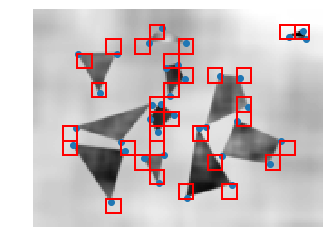

转化后


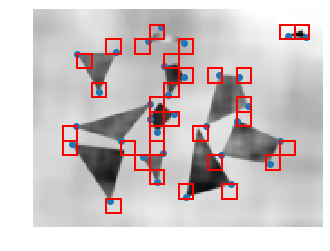

In [10]:
# train_data_with_point = SyntheticData(train_csv,dataset_root,True)
# sample =train_data_with_point[40800]
# # print(sample['pt'])
# img,label,points = sample['img'],sample['label'],sample['pt']
# # print(label)
# pt = label2point(label)
# print("转化前")
# visulize(img,label,points)
# print("转化后")
# visulize(img,label,pt)

转化后，每个框中只有一个关键点，且点的位置均向左上角有微小偏移，这是因为向下取整的缘故

## 查看数据集

In [8]:
def input_sample():
    for i,sample in enumerate(train_loader):
        imgs = sample['img']
        labels = sample['label']
        for j in range(batch_size):
            img = imgs[j]
            label = labels[j]
            points = label2point(label)
            visulize(img,label,points)
        if i == 0:
            break

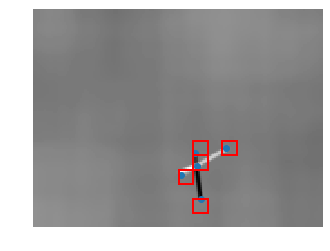

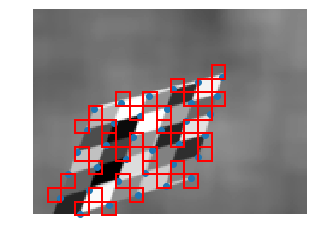

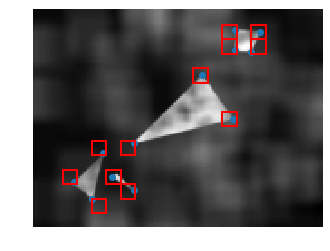

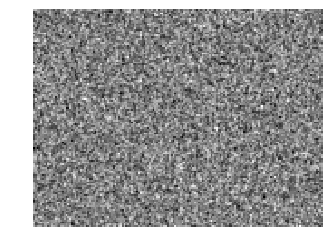

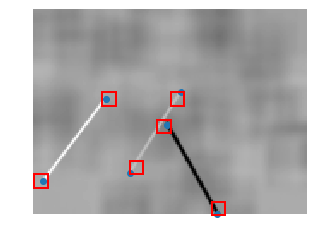

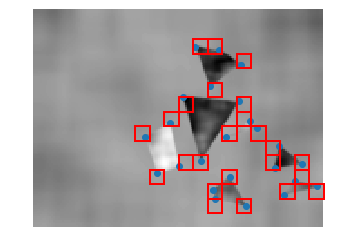

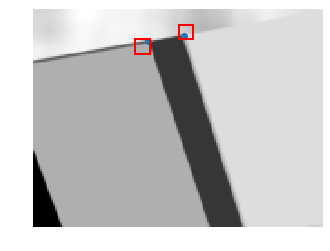

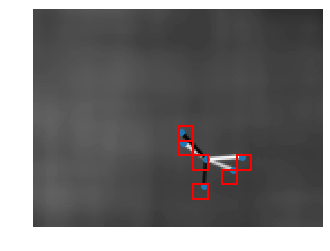

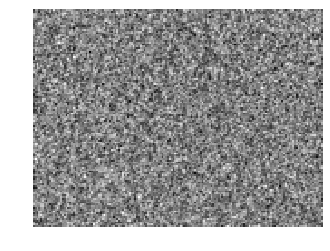

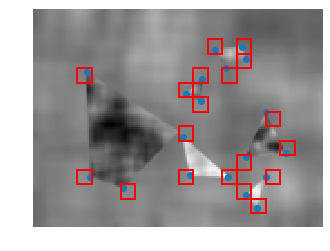

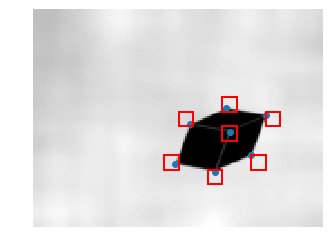

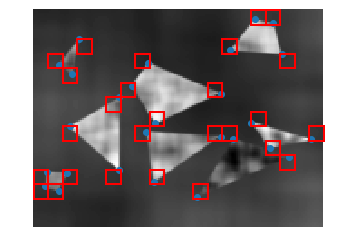

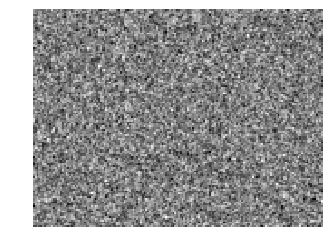

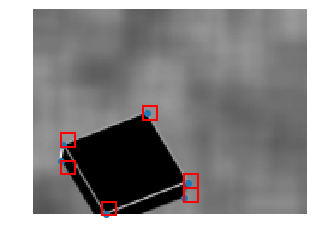

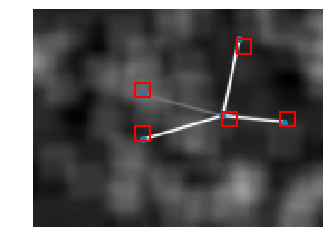

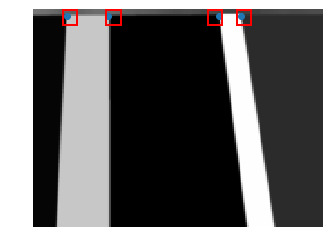

In [9]:
input_sample()

## 定义网络

In [10]:
class SuperPointNet(torch.nn.Module):
    """ Pytorch definition of SuperPoint Network. """

    def __init__(self):
        super(SuperPointNet, self).__init__()
        self.relu = torch.nn.ReLU(inplace=True)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        c1, c2, c3, c4, c5, d1 = 64, 64, 128, 128, 256, 256
        # Shared Encoder.
        self.conv1a = torch.nn.Conv2d(1, c1, kernel_size=3, stride=1, padding=1)
        self.conv1b = torch.nn.Conv2d(c1, c1, kernel_size=3, stride=1, padding=1)
        self.conv2a = torch.nn.Conv2d(c1, c2, kernel_size=3, stride=1, padding=1)
        self.conv2b = torch.nn.Conv2d(c2, c2, kernel_size=3, stride=1, padding=1)
        self.conv3a = torch.nn.Conv2d(c2, c3, kernel_size=3, stride=1, padding=1)
        self.conv3b = torch.nn.Conv2d(c3, c3, kernel_size=3, stride=1, padding=1)
        self.conv4a = torch.nn.Conv2d(c3, c4, kernel_size=3, stride=1, padding=1)
        self.conv4b = torch.nn.Conv2d(c4, c4, kernel_size=3, stride=1, padding=1)
        # Detector Head.
        self.convPa = torch.nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
        self.convPb = torch.nn.Conv2d(c5, 65, kernel_size=1, stride=1, padding=0)
        # Descriptor Head.
        self.convDa = torch.nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
        self.convDb = torch.nn.Conv2d(c5, d1, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        """ Forward pass that jointly computes unprocessed point and descriptor
        tensors.
        Input
          x: Image pytorch tensor shaped N x 1 x H x W.
        Output
          semi: Output point pytorch tensor shaped N x 65 x H/8 x W/8.
          desc: Output descriptor pytorch tensor shaped N x 256 x H/8 x W/8.
        """
        # Shared Encoder.
        x = self.relu(self.conv1a(x))
        x = self.relu(self.conv1b(x))
        x = self.pool(x)
        x = self.relu(self.conv2a(x))
        x = self.relu(self.conv2b(x))
        x = self.pool(x)
        x = self.relu(self.conv3a(x))
        x = self.relu(self.conv3b(x))
        x = self.pool(x)
        x = self.relu(self.conv4a(x))
        x = self.relu(self.conv4b(x))

        # Detector Head.
        cPa = self.relu(self.convPa(x))
        semi = self.convPb(cPa)
        # Descriptor Head.
#         cDa = self.relu(self.convDa(x))
#         desc = self.convDb(cDa)
#         dn = torch.norm(desc, p=2, dim=1)  # Compute the norm.
#         desc = desc.div(torch.unsqueeze(dn, 1))  # Divide by norm to normalize.
        return semi #, desc

net = SuperPointNet()

## 采样显示输出

In [11]:
def sample_output():
    for i,sample in enumerate(train_loader):
        imgs = sample['img'].view((-1,1,H,W))
        labels = sample['label']
        print(imgs.shape)
        outputs = net(imgs)
        
        if i == 0:
            return imgs,labels,outputs
        
        
def output2points(output,alpha=0.5):
    output = np.exp(output.detach().numpy()) # Softmax.
    output = output / (np.sum(output, axis=0) + .00001)  # Should sum to 1.
    output = output[:-1,:,:]
    output = output.transpose(1,2,0)
    output = output.reshape((Hc,Wc,8,8))
    output = output.transpose(0,2,1,3)
    output = output.reshape(H,W)
    # print(output.shape)
    # print(output[output > alpha])
    xs,ys = np.where(output > alpha)
    points = np.vstack((xs,ys)).T
    print(f'there are {len(points)} points')
    return points

torch.Size([16, 1, 120, 160])
torch.Size([1, 120, 160])
there are 1118 points


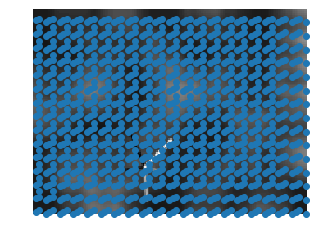

In [13]:
imgs,labels,outputs = sample_output()
img = imgs[0]
print(img.shape)
label = labels[0]
output = outputs[0]

points = output2points(output,alpha=0.0163)
visulize(img,pt=points)

## 开始训练

In [24]:
net = SuperPointNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(params=net.parameters(),lr=0.0001)

In [ ]:
n_epoch = 10
for epoch in range(n_epoch):
    for i,sample in enumerate(train_loader):
        imgs = sample['img'].view((-1,1,H,W))
        labels = sample['label']
        
        outputs = net(imgs)
        loss = criterion(outputs,labels)
#         for i in range(Hc):
#             for j in range(Wc):
#                 # print(outputs[:,:,i,j].shape,labels[:,i,j].shape)
#                 loss += criterion(outputs[:,:,i,j],labels[:,i,j])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.data
        
        if i%10 == 9:
            print(f"epoch:{epoch+1},batch:{i+1},AVG.loss:{running_loss/batch_size/10}")
            running_loss = 0.0

epoch:1,batch:10,AVG.loss:0.34055498242378235
epoch:1,batch:20,AVG.loss:0.26322048902511597
epoch:1,batch:30,AVG.loss:0.26314666867256165
epoch:1,batch:40,AVG.loss:0.26307958364486694
epoch:1,batch:50,AVG.loss:0.2630019187927246
epoch:1,batch:60,AVG.loss:0.26292601227760315
epoch:1,batch:70,AVG.loss:0.2628517150878906


In [184]:
labels.shape

torch.Size([16, 15, 20])

In [186]:
labels[:,1,1].shape

torch.Size([16])

In [187]:
outputs[:,:,1,1].shape

torch.Size([16, 65])